# Federated Learining - TBD

[Link to Colab (deprecated)](https://colab.research.google.com/drive/1GmAhxnKVvrhWffospDEe0rc-QB_tjfhE?usp=sharing)

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random

from src.custom_types import TypeEnum
from src.tf_layer_constructors import (
    gen_normalization_layer,
    gen_multihot_categorical_encoding_layer
)
from src.tf_utils import df_to_tfds
from src.data_examples.ex1_data_loader import ExampleDataLoader

In [19]:
RAND_SEED = 1337

np.random.seed(RAND_SEED)
random.seed(RAND_SEED)
np.set_printoptions(precision=3, suppress=True)

tf.keras.backend.clear_session()

## Loading Example Data

In [20]:
data = ExampleDataLoader()
data.download().load().clean()

using cached file cache\static\public\10\automobile.zip
extracting zip file content:
 	size: 144	filename: Index
 	size: 1197	filename: app.css
 	size: 25936	filename: imports-85.data
 	size: 4747	filename: imports-85.names
 	size: 3757	filename: misc


In [21]:
data.df['symboling-threshold'] = [1 if i > 0 else 0 for i in data.df['symboling']]

feature_label = 'symboling-threshold'

In [22]:
data.df

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,symboling-threshold
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.800003,...,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0,1
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.400002,...,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0,1
6,1,158.0,audi,gas,std,four,sedan,fwd,front,105.800003,...,mpfi,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,17710.0,1
8,1,158.0,audi,gas,turbo,four,sedan,fwd,front,105.800003,...,mpfi,3.13,3.40,8.3,140.0,5500.0,17.0,20.0,23875.0,1
10,2,192.0,bmw,gas,std,two,sedan,rwd,front,101.199997,...,mpfi,3.50,2.80,8.8,101.0,5800.0,23.0,29.0,16430.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.099998,...,mpfi,3.78,3.15,9.5,114.0,5400.0,23.0,28.0,16845.0,0
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.099998,...,mpfi,3.78,3.15,8.7,160.0,5300.0,19.0,25.0,19045.0,0
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.099998,...,mpfi,3.58,2.87,8.8,134.0,5500.0,18.0,23.0,21485.0,0
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.099998,...,idi,3.01,3.40,23.0,106.0,4800.0,26.0,27.0,22470.0,0


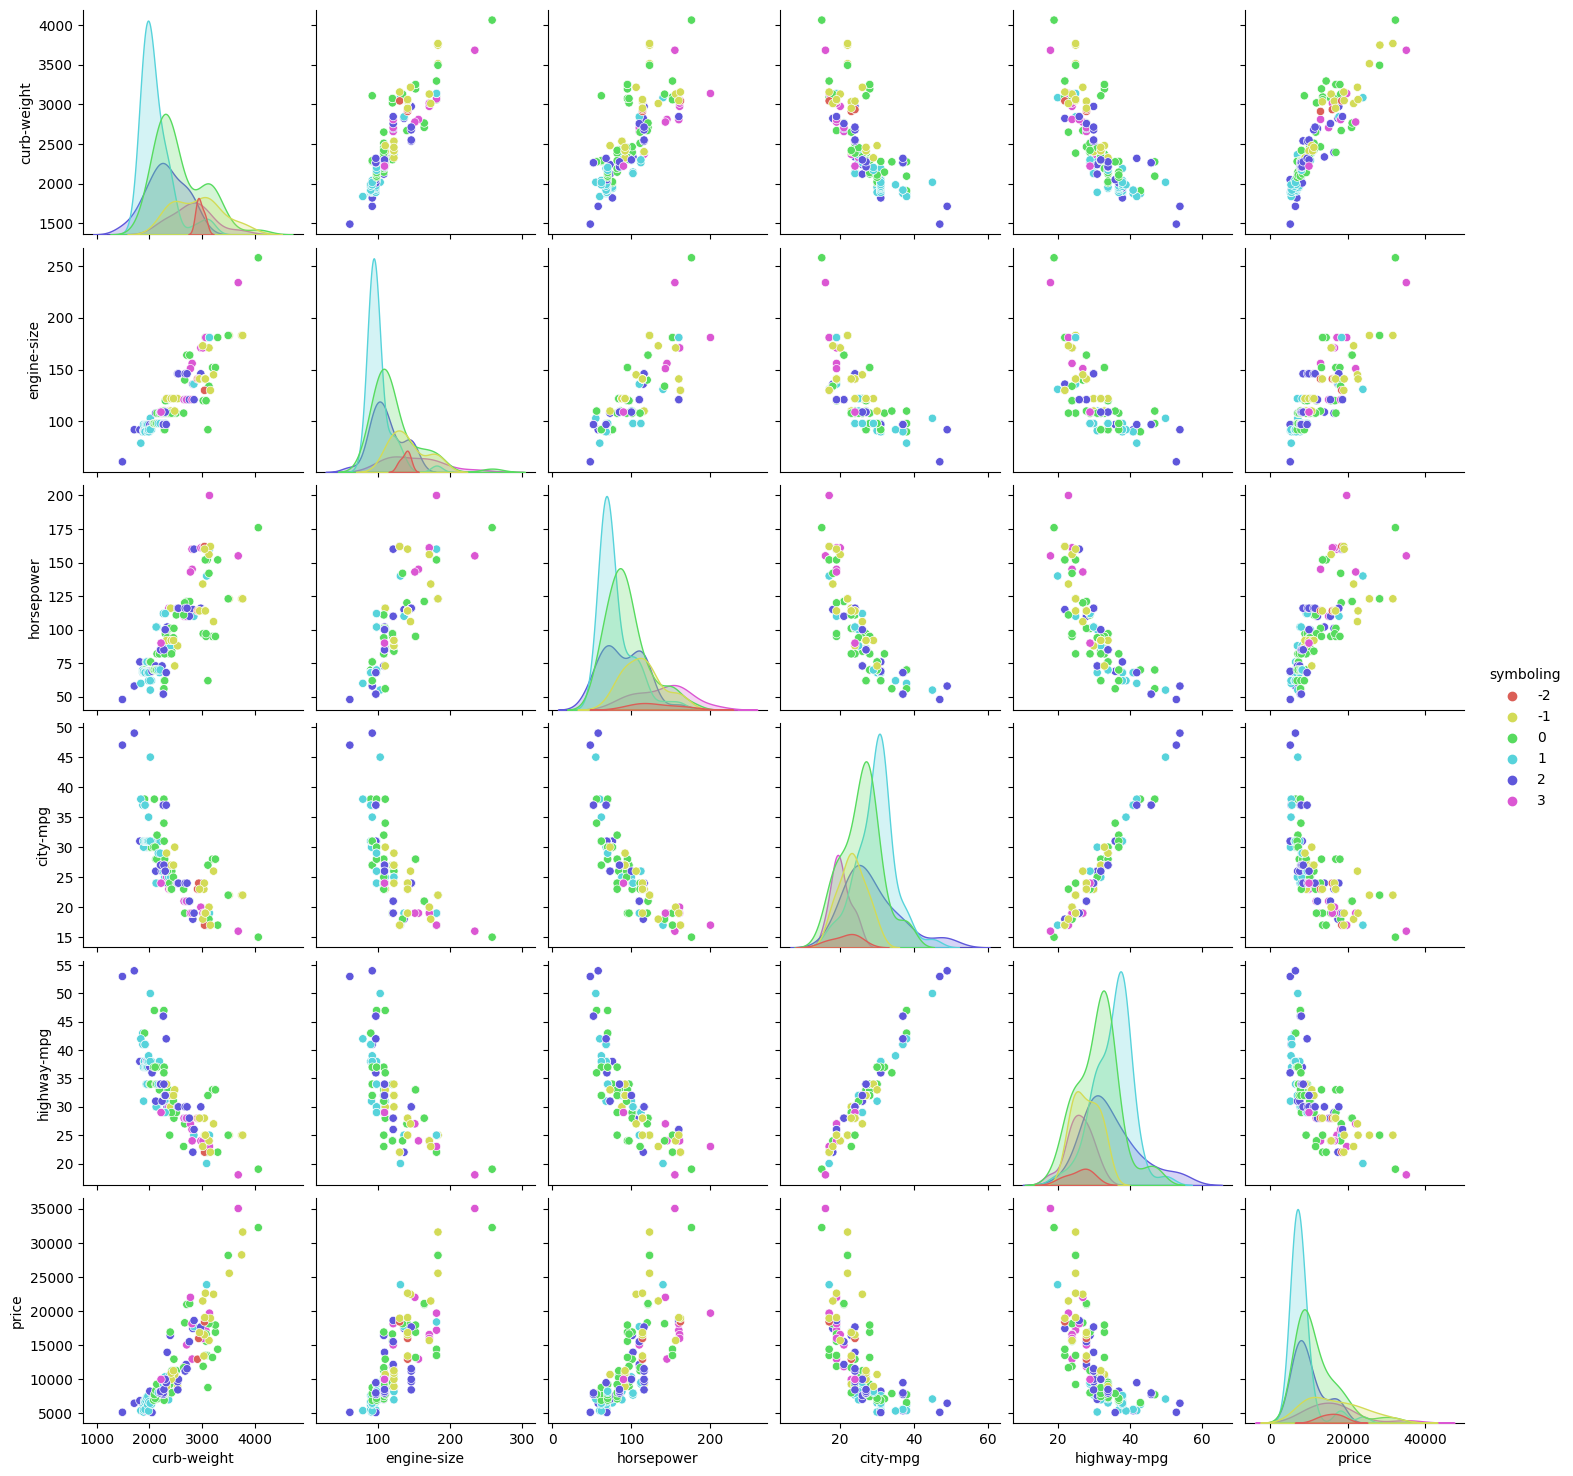

In [23]:
sns.pairplot(
  data.df[[
    data.label_name,
    "curb-weight",
    "engine-size",
    "horsepower",
    # "peak-rpm",
    "city-mpg",
    "highway-mpg",
    "price"
  ]], diag_kind='kde', hue=data.label_name, palette=sns.color_palette('hls', len(data.df[data.label_name].unique())))

## 1. Conventional Training 

In [24]:
df_train = data.df.sample(frac=0.8, random_state=RAND_SEED)
df_val_test = data.df.drop(df_train.index)
df_test = df_val_test.sample(frac=0.5, random_state=RAND_SEED)
df_val = df_val_test.drop(df_test.index)

df_train.shape, df_test.shape, df_val.shape

((127, 27), (16, 27), (16, 27))

In [25]:
batch_size = 24

tfds_train  = df_to_tfds(df_train, feature_label, batch_size=batch_size, )
tfds_test   = df_to_tfds(df_test,  feature_label, batch_size=batch_size, )
tfds_val    = df_to_tfds(df_val,   feature_label, batch_size=batch_size, )

c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}
c:\Users\62896\Documents\GitHub\FederatedLearning\src\tf_utils.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  c_df = {key: value[:,tf.newaxis] for key, value in df.items()}


In [26]:
all_inputs = {}
all_encoded_features = {}

In [27]:
all_inputs['normalization'] = {}
all_encoded_features['normalization'] = {}

for col_name in data.features_numeric:
  dtype = data.data_types_numeric.get(col_name)

  input_numeric = tf.keras.Input(shape=(1,), name=col_name, dtype='float32')
  normalization_layer = gen_normalization_layer(tfds_train, col_name)
  encoded_normalized_input = normalization_layer(input_numeric)

  all_inputs['normalization'][col_name] = input_numeric
  all_encoded_features['normalization'][col_name] = encoded_normalized_input

In [28]:
all_inputs['categorical'] = {}
all_encoded_features['categorical'] = {}

for col_name in data.features_categorical:
  input_categorical = tf.keras.Input(shape=(1,), name=col_name, dtype='string')
  categorical_encoder = gen_multihot_categorical_encoding_layer(tfds_train, col_name, TypeEnum.string)
  encoded_categorical_input = categorical_encoder(input_categorical)

  all_inputs['categorical'][col_name] = input_categorical
  all_encoded_features['categorical'][col_name] = encoded_categorical_input

In [29]:
all_inputs

{'normalization': {'curb-weight': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'curb-weight')>,
  'engine-size': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'engine-size')>,
  'horsepower': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'horsepower')>,
  'peak-rpm': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'peak-rpm')>},
 'categorical': {'make': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'make')>,
  'engine-type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'engine-type')>}}

In [30]:
def build_categorical_model(input_layers, feature_layers):
  nn_dense = tf.keras.layers.Dense(32, activation='relu')(feature_layers)
  nn_dense = tf.keras.layers.Dropout(0.5)(nn_dense)
  output = tf.keras.layers.Dense(1)(nn_dense)
  return tf.keras.Model(input_layers, output)


In [31]:
all_feature_layers = tf.keras.layers.concatenate([j for i in all_encoded_features.values() for j in i.values()])

model = build_categorical_model(all_inputs, all_feature_layers)

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [33]:
model.fit(tfds_train, epochs=10, validation_data=tfds_val)

Epoch 1/10
6/6 [==============================] - 1s 34ms/step - loss: 1.4452 - accuracy: 0.5433 - val_loss: 0.9722 - val_accuracy: 0.5625
Epoch 2/10
6/6 [==============================] - 0s 4ms/step - loss: 1.1006 - accuracy: 0.6142 - val_loss: 0.8174 - val_accuracy: 0.5625
Epoch 3/10
6/6 [==============================] - 0s 5ms/step - loss: 1.1277 - accuracy: 0.5039 - val_loss: 0.7012 - val_accuracy: 0.5625
Epoch 4/10
6/6 [==============================] - 0s 4ms/step - loss: 1.1133 - accuracy: 0.5197 - val_loss: 0.6388 - val_accuracy: 0.8125
Epoch 5/10
6/6 [==============================] - 0s 5ms/step - loss: 1.0694 - accuracy: 0.5669 - val_loss: 0.6003 - val_accuracy: 0.6875
Epoch 6/10
6/6 [==============================] - 0s 4ms/step - loss: 0.9277 - accuracy: 0.5354 - val_loss: 0.5897 - val_accuracy: 0.7500
Epoch 7/10
6/6 [==============================] - 0s 4ms/step - loss: 1.1635 - accuracy: 0.5433 - val_loss: 0.5873 - val_accuracy: 0.8125
Epoch 8/10
6/6 [=================

In [34]:
loss, accuracy = model.evaluate(tfds_test)
print("Accuracy", accuracy)

1/1 [==============================] - 0s 19ms/step - loss: 0.6309 - accuracy: 0.6875
Accuracy 0.6875
